# Exploring a new dataset

One of the most important steps in ecological machine learning is defining the problem and understanding the data. In this notebook I look at general strategies for successful machine learning. 

1. What does the data look like?
2. What existing models can help?
3. How can we fine-tune existing models to customize to our data?
4. How better clean the data to reduce the noise and focus on the key elements?
5. How can we organize and track train and test splits to increase predictive accuracy?

To highlight these concepts, intentionally chose a dataset I have no experience with.

In [3]:
from opensoundscape.ml.cnn import load_model
from opensoundscape import Audio

Cargando datos...
Datos de entrenamiento: (28564, 13)
Datos taxonómicos: (206, 5)
Archivo de muestra: (3, 207)

=== Análisis de Distribución de Especies ===

Total de especies únicas: 206
Especie más común: grekis (990 registros)
Especie menos común: 1139490 (2 registros)


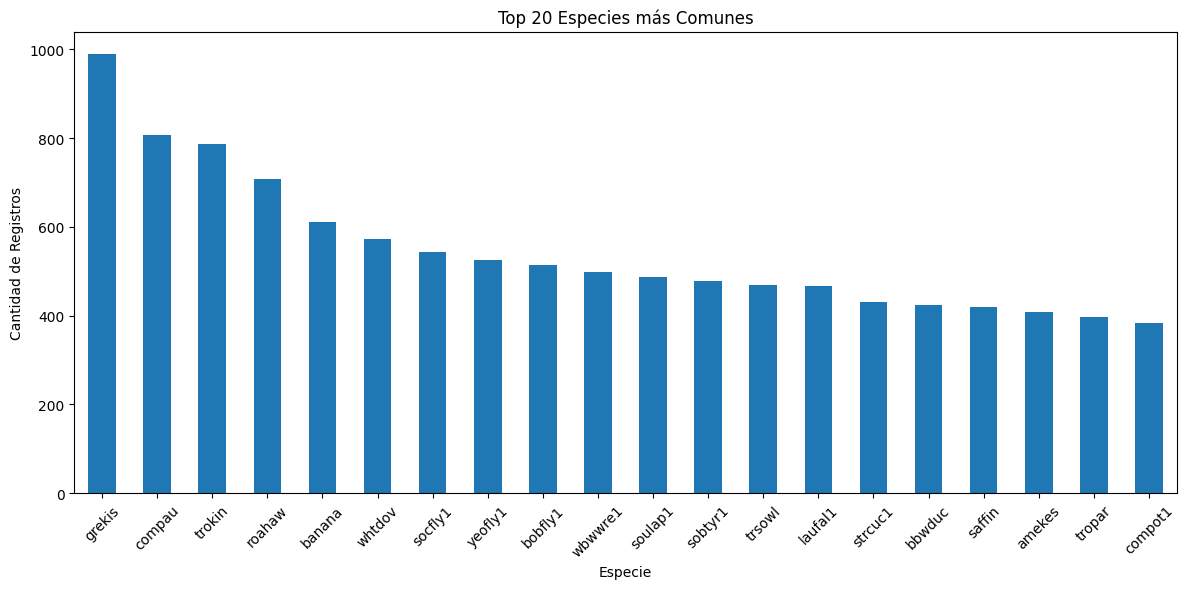

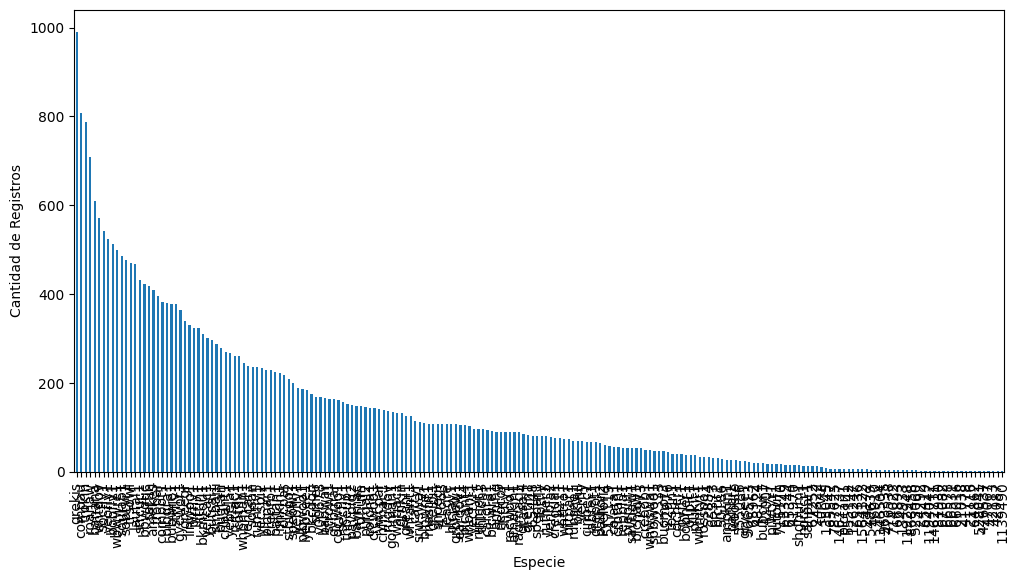

In [64]:
# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from pathlib import Path

def analizar_distribucion_especies(train_df):
    """
    Analiza la distribución de especies en el conjunto de datos.
    Args:
        train_df (DataFrame): DataFrame de entrenamiento
    """
    print("\n=== Análisis de Distribución de Especies ===")
    
    # Análisis de distribución de especies
    species_counts = train_df['primary_label'].value_counts()
    
    # Visualización de las 20 especies más comunes
    plt.figure(figsize=(12, 6))
    species_counts.head(20).plot(kind='bar')
    plt.title('Top 20 Especies más Comunes')
    plt.xlabel('Especie')
    plt.ylabel('Cantidad de Registros')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    print(f"\nTotal de especies únicas: {len(species_counts)}")
    print(f"Especie más común: {species_counts.index[0]} ({species_counts.iloc[0]} registros)")
    print(f"Especie menos común: {species_counts.index[-1]} ({species_counts.iloc[-1]} registros)")

    # Visualización de las 20 especies más comunes
    plt.figure(figsize=(12, 6))
    species_counts.plot(kind='bar')
    plt.xlabel('Especie')
    plt.ylabel('Cantidad de Registros')

def cargar_datos():
    """
    Carga los archivos principales del conjunto de datos.
    Returns:
        tuple: DataFrames de entrenamiento, taxonomía y muestra
    """
    print("Cargando datos...")
    
    # Carga de archivos principales
    train_df = pd.read_csv("../birdclef-2025/train.csv")
    taxonomy_df = pd.read_csv("../birdclef-2025/taxonomy.csv")
    sample_submission = pd.read_csv("../birdclef-2025/sample_submission.csv")
    
    # Carga de metadatos de ubicación
    with open("../birdclef-2025/recording_location.txt", "r") as f:
        recording_location = f.read()
    
    print(f"Datos de entrenamiento: {train_df.shape}")
    print(f"Datos taxonómicos: {taxonomy_df.shape}")
    print(f"Archivo de muestra: {sample_submission.shape}")
    
    return train_df, taxonomy_df, sample_submission, recording_location

train_df, taxonomy_df, sample_submission, recording_location = cargar_datos()

analizar_distribucion_especies(train_df)
plt.show()

## Load model

https://github.com/kitzeslab/bioacoustics-model-zoo?tab=readme-ov-file

In [37]:
# Opensoundscape and BirdCLEF
import bioacoustics_model_zoo as bmz

# list available models from the model zoo
bmz.utils.list_models()

# Load the model
m=bmz.BirdSetEfficientNetB1()

/Users/benweinstein/miniconda3/envs/megadetector/lib/python3.11/site-packages/opensoundscape/ml/cnn.py:621: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/Users/

Let's choose a fairly common bird species with a distinctive call.

https://ebird.org/species/yelori1


In [43]:
yellow_oriole = train_df[train_df.common_name == "Yellow Oriole"]
yellow_oriole.head()





,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
27535,yelori1,[''],['song'],yelori1/XC115508.ogg,XC,5.0,https://xeno-canto.org/115508,4.7820,-71.7740,Icterus nigrogularis,Yellow Oriole,Oswaldo Cortes,cc-by-nc-sa 3.0
27536,yelori1,[''],['song'],yelori1/XC127962.ogg,XC,3.0,https://xeno-canto.org/127962,4.1809,-72.9136,Icterus nigrogularis,Yellow Oriole,Oswaldo Cortes,cc-by-nc-sa 3.0
27537,yelori1,[''],['song'],yelori1/XC127963.ogg,XC,4.0,https://xeno-canto.org/127963,4.1809,-72.9136,Icterus nigrogularis,Yellow Oriole,Oswaldo Cortes,cc-by-nc-sa 3.0
27538,yelori1,[''],['call'],yelori1/XC142091.ogg,XC,3.0,https://xeno-canto.org/142091,5.0901,-52.5698,Icterus nigrogularis,Yellow Oriole,Michel Giraud-Audine,cc-by-nc-sa 3.0
27539,yelori1,[''],['call'],yelori1/XC15038.ogg,XC,3.0,https://xeno-canto.org/15038,10.6051,-61.4292,Icterus nigrogularis,Yellow Oriole,Todd Mark,cc-by-nc-sa 3.0


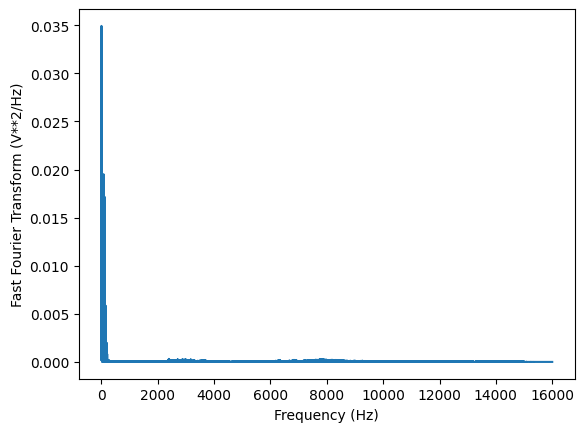

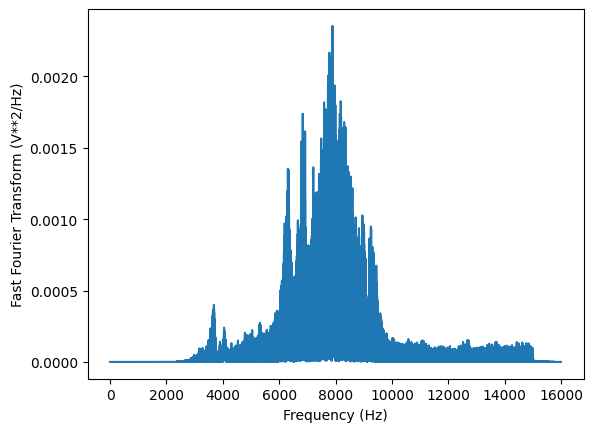

In [85]:
# Load the audio
file_path = "../birdclef-2025/train_audio/yelori1/XC142091.ogg"
audio = Audio.from_file(file_path)
fft_spectrum, frequencies = audio.spectrum()

# Plot settings
from matplotlib import pyplot as plt

# Plot
plt.plot(frequencies,fft_spectrum)
plt.ylabel('Fast Fourier Transform (V**2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.show()

# Low pass filter
fft_spectrum, frequencies = audio.highpass(4000, order=6).normalize().spectrum()

# Plot
plt.plot(frequencies,fft_spectrum)
plt.ylabel('Fast Fourier Transform (V**2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.show()
audio.show_widget()

## Predict use pretrained model

In [46]:
scores = m.predict(file_path, activation_layer="sigmoid")    

  0%|          | 0/8 [00:00<?, ?it/s]

## Analyze the predictions

I'm nearly certain that this prebuilt model predicts "altori" -> https://ebird.org/species/altori. But that does not occur in the Kaggle set.

In [59]:
# Look up training data
train_df[train_df.common_name == "Altamira Oriole"]

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license


In [58]:
from opensoundscape.metrics import predict_multi_target_labels
predicted_labels = predict_multi_target_labels(scores, threshold=0.1)
predicted_labels
# count the number of detections for each species
detection_counts = predicted_labels.sum(0)
detections = detection_counts[detection_counts > 0]

print(detections)

# Matching taxonomy
taxonomy_df.loc[taxonomy_df.primary_label.isin(detections.index)]

strher     2
shcfly1    3
comior1    1
altori     2
antwre2    1
blsspa1    1
dtype: int64


,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license


# Lessons learned

1. Data formats and installation are the hardest part of getting started. Most projects fail here.
2. Taxonomy is a persistant challenge.
3. Generalization across time and space limits open source models

# Next steps
1. Aligning taxonomies of existing models and our dataset
2. Intelligent preprocessing to focus on the target species. 
3. Training our own classifier starting from this existing model.

____________________

# Fine-tuning

If there is one overarching lesson from the last 10 years of ecological machine learning research, its that starting from existing backbone is the most common strategy for success. Data from a suprisingly wide array of sources can be useful. Let's retrain this backbone with our classes. 

In [65]:
m


BirdSetEfficientNetB1(
  (network): EfficientNetLogits(
    (efficientnet): EfficientNetModel(
      (embeddings): EfficientNetEmbeddings(
        (padding): ZeroPad2d((0, 1, 0, 1))
        (convolution): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=valid, bias=False)
        (batchnorm): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (activation): SiLU()
      )
      (encoder): EfficientNetEncoder(
        (blocks): ModuleList(
          (0): EfficientNetBlock(
            (depthwise_conv): EfficientNetDepthwiseLayer(
              (depthwise_conv_pad): ZeroPad2d((0, 1, 0, 1))
              (depthwise_conv): EfficientNetDepthwiseConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32, bias=False)
              (depthwise_norm): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
              (depthwise_act): SiLU()
            )
            (squeeze_excite): EfficientNetSqueezeExcite

By looking at this model statement, we can see we need embeddings of size 1280 and strip off the top layer. We can keep the bottom layers by freezing the backbone. Following the README.md https://github.com/kitzeslab/bioacoustics-model-zoo

In [67]:
m.freeze_feature_extractor()
labels = train_df.primary_label.unique()
m.change_classes(labels)

# load one-hot labels and train (index: (file,start_time,end_time))
train_df = pd.read_csv('train_labels.csv',index_col=[0,1,2])
val_df = pd.read_csv('val_labels.csv',index_col=[0,1,2])
m.train(train_df, val_df,batch_size=128, num_workers=8)